In [1]:
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"

In [2]:
from langchain.globals import set_debug, set_verbose

set_verbose(True)
set_debug(False)

In [3]:
from langchain_core.messages import HumanMessage
import operator
import functools

# for llm model
from langchain_openai import ChatOpenAI
# from langchain_community.chat_models import ChatOpenAI
from tools import find_place_from_text, nearby_search, nearby_dense_community
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    BaseMessage,
    ToolMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

## Document vector store for context
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import CSVLoader
from langchain_openai import OpenAIEmbeddings
import glob
from langchain.tools.retriever import create_retriever_tool

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


## Document csv
# Specify the pattern
file_pattern = "document/*.csv"
file_paths = tuple(glob.glob(file_pattern))

all_docs = []

for file_path in file_paths:
    loader = CSVLoader(file_path=file_path)
    docs = loader.load()
    all_docs.extend(docs)  # Add the documents to the list

# Split text into chunks separated.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(all_docs)

# Text Vectorization.
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()


## tools and LLM
retriever_tool = create_retriever_tool(
    retriever,
    "search_population_community_household_expenditures_data",
    "Use this tool to retrieve information about population, community and household expenditures. by searching distinct or province"
)

# Bind the tools to the model
tools = [retriever_tool, find_place_from_text, nearby_search, nearby_dense_community]  # Include both tools if needed
# tools = [find_place_from_text, nearby_search]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

## Create agents
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " "
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    #llm_with_tools = llm.bind(functions=[format_tool_to_openai_function(t) for t in tools])
    return prompt | llm.bind_tools(tools)
    #agent = prompt | llm_with_tools
    #return agent


## Define state
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


## Define Agents Node
# Research agent and node
from prompt import agent_meta
agent_name = [meta['name'] for meta in agent_meta]

agents={}
agent_nodes={}

for meta in agent_meta:
    name = meta['name']
    prompt = meta['prompt']
    
    agents[name] = create_agent(
            llm,
            tools,
            system_message=prompt,
        )
    
    agent_nodes[name] = functools.partial(agent_node, agent=agents[name], name=name)


## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(tools)

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "continue" in last_message.content:
        return "continue"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    else:
        return "continue"



## Workflow Graph
workflow = StateGraph(AgentState)

# add agent nodes
for name, node in agent_nodes.items():
    workflow.add_node(name, node)
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    router,
    {"continue": "data_collector", "call_tool": "call_tool", "__end__": END}
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {"call_tool": "call_tool", "continue": "reporter", "__end__": END}
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {"continue": "data_collector", "call_tool": "call_tool", "__end__": END}
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)
workflow.add_edge(START, "analyst")
graph = workflow.compile()

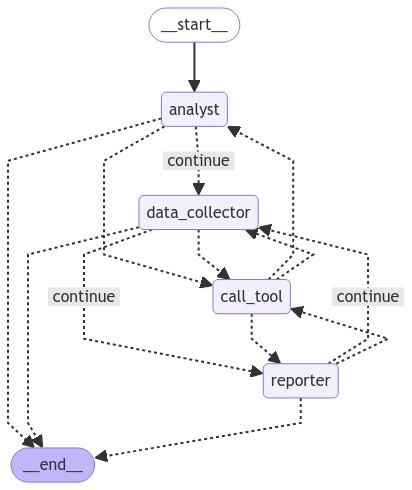

In [4]:
# from IPython.display import Image, display

# try:
#     display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

In [5]:
# question = "วิเคราะห์การเปิดร้านอาหารใกล้สยามพารากอน"

# graph = workflow.compile()

# events = graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 question
#             )
#         ],
#     },
#     # Maximum number of steps to take in the graph
#     {"recursion_limit": 20},
# )
# for s in events:
#     # print(s)
#     a = list(s.items())[0]
#     a[1]['messages'][0].pretty_print()

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_tROHQnQOgJ3lY9WcqHjwciAl)
 Call ID: call_tROHQnQOgJ3lY9WcqHjwciAl
  Args:
    location: Siam Paragon
  nearby_dense_community (call_tLA9CsprV2cdd3PAi5MkqZ8c)
 Call ID: call_tLA9CsprV2cdd3PAi5MkqZ8c
  Args:
    location_name: Siam Paragon
    radius: 1000
================================= Tool Message =================================
Name: find_place_from_text


    address: 991/1 ถ. พระรามที่ 1 แขวงปทุมวัน เขตปทุมวัน กรุงเทพมหานคร 10330 ไทย

    location: {'lat': 13.7457749, 'lng': 100.5344017}

    location_name: สยามพารากอน

    
================================== Ai Message ==================================
Name: analyst
Tool Calls:
  nearby_dense_community (call_YdlTeBbdBBfiXlNE38pqI6g3)
 Call ID: call_YdlTeBbdBBfiXlNE38pqI6g3
  Args:
    input_dict: {'location_name': 'Siam Paragon', 'radius': 1000}
================================= Tool Message 

In [6]:
def submitUserMessage(user_input: str) -> str:
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": 20},
    )
    
    events = [e for e in events]
    
    response = list(events[-1].values())[0]["messages"][0]
    response = response.content
    response = response.replace("FINAL ANSWER", "")
    
    return response


# question = "วิเคราะห์ร้านอาหารแถวลุมพินี เซ็นเตอร์ ลาดพร้าว"
# submitUserMessage(question)